In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
#import lightgbm as lgb
import scipy
import dask
import sys
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import time
import datetime
from datetime import date, datetime, timedelta
import pickle
import shap


In [2]:
sys.path.append("/Users/galynagrynkiv/Desktop/Liquid Analytics/WFS/Collections/LA/")
#sys.path.append( "/Users/sergiipypko/Desktop/Liquid Analytics/WF/Collections/LA/")

from importlib import reload
import data_manipulation as dm
import models
reload(dm)
reload(models)

warnings.filterwarnings('ignore') 

# (0) Load data

In [3]:
#folder_path = '/Users/galynagrynkiv/Desktop/Liquid Analytics/WFS/Collections/LA/'
#folder_path =  "/Users/sergiipypko/Desktop/Liquid Analytics/WF/Collections/LA/"
#folder_path = '/Macintosh HD⁩/⁨Users⁩/⁨galynagrynkiv⁩/⁨Desktop⁩/⁨Liquid Analytics⁩/WFS⁩/⁨Collections⁩/LA/'

folder_path = '/Users/galynagrynkiv/Desktop/Liquid Analytics/WFS/Collections/LA/'
raw = pd.read_csv(folder_path + 'data.csv')

#raw = raw.drop(['Unnamed: 0', 'index'], axis = 1)
raw = raw.drop(['Unnamed: 0'], axis = 1)
#raw['Date'] = pd.to_datetime(raw['Date'])
raw.rename(columns={'TRX_NUMBER':'xt'}, inplace = True)



In [4]:
raw.head(2)

,ACCOUNT_NUMBER,ACCOUNT_NAME,CUST_ACCOUNT_ID,LOCATION,xt,TRX_DATE,TRANSACTION_STATUS,AMOUNT_DUE_ORIGINAL,AMOUNT_DUE_REMAINING,POI_NUMBER,...,avrg_name_amount,avrg_name_dtc,Account_name_activity,avrg_account_amount,avrg_account_dtc,Account_activity,DUE_DATE_Month,DUE_DATE_day,TRX_DATE_Month,TRX_DATE_day
0,100045,BLUE FIN TANKERS C/O HEIDENREICH MARINE INC,100095,WFS,100469-31193,2018-12-05,OP,205224.62,0.0,3055796,...,482269.553077,-0.166667,13,482269.553077,-0.166667,13,Dec,Friday,Dec,Wednesday
1,100045,BLUE FIN TANKERS C/O HEIDENREICH MARINE INC,100095,WFS,110620-31222,2018-07-23,OP,921630.72,0.0,3027685,...,481175.327500,0.000000,8,481175.327500,0.000000,8,Aug,Saturday,Jul,Monday


In [5]:
joint = pd.DataFrame(raw).copy(deep = True)
joint = joint.dropna()
joint.columns

Index(['ACCOUNT_NUMBER', 'ACCOUNT_NAME', 'CUST_ACCOUNT_ID', 'LOCATION', 'xt',
       'TRX_DATE', 'TRANSACTION_STATUS', 'AMOUNT_DUE_ORIGINAL',
       'AMOUNT_DUE_REMAINING', 'POI_NUMBER', 'LIFT_DATE', 'DUE_DATE',
       'RECEIPT_NUMBER', 'RECEIPT_DATE', 'APPLY_DATE', 'AMOUNT_APPLIED',
       'RECEIPT_STATUS', 'PAYMENT_TERMS', 'NAME', 'DESC_PAYMENTERMS',
       'DESCRIPTION', 'AMOUNT_REMAINING_GEN', 'share_not_paid', 'DPT', 'DTI',
       'DTC', 'DTD', 'DTR', 'avrg_name_amount', 'avrg_name_dtc',
       'Account_name_activity', 'avrg_account_amount', 'avrg_account_dtc',
       'Account_activity', 'DUE_DATE_Month', 'DUE_DATE_day', 'TRX_DATE_Month',
       'TRX_DATE_day'],
      dtype='object')

In [6]:
#sort by  by transaction date
joint.sort_values(by = 'TRX_DATE', inplace = True)
joint.reset_index(inplace = True)
#joint.head(2)

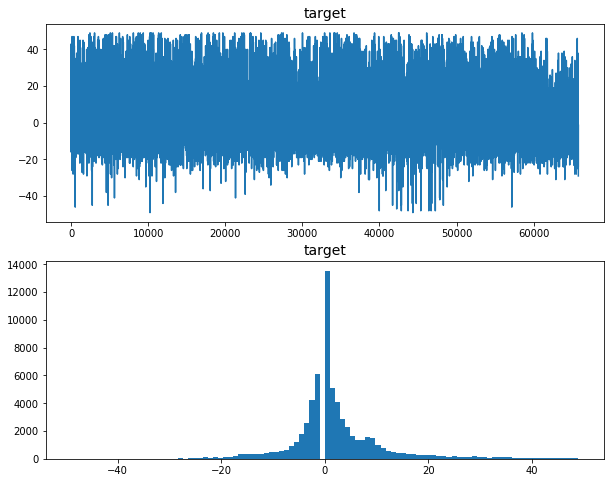

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(joint['DTC'])
plt.title('target', fontsize = 14)



plt.subplot(2,1,2)
plt.hist(joint['DTC'], 100)
plt.title('target', fontsize = 14)



plt.show()

In [8]:
joint[['TRX_DATE', "DUE_DATE", "RECEIPT_DATE", "APPLY_DATE", "LIFT_DATE"]] = \
       joint[['TRX_DATE', "DUE_DATE", "RECEIPT_DATE", "APPLY_DATE", "LIFT_DATE"]].\
       apply(pd.to_datetime)

#### Do encoding (get dummy variables for categorical variables)

In [9]:
categorical_ft = [
                  'ACCOUNT_NAME',
                  'LOCATION',  
                  'PAYMENT_TERMS', 
                  'NAME',
                  'DESCRIPTION',
                  'DUE_DATE_Month',
                  'DUE_DATE_day' ,
                  'TRX_DATE_Month',
                  'TRX_DATE_day'] 
# tmp = joint[categorical_ft].copy()
for idx_cat_ft in categorical_ft:
    joint[idx_cat_ft] = joint[idx_cat_ft].astype('category')
    joint[idx_cat_ft] = joint[idx_cat_ft].cat.codes


# (1) Estimate models

#### Split data into train-test

In [61]:
lenght = joint.shape[0]
share = 0.7
train = joint.loc[0:int(lenght*share)]
test = joint.loc[int(lenght*share)+1:]

# Specify list of features and target

factors_ft = [ 
              #'ACCOUNT_NUMBER', 
               'ACCOUNT_NAME',
                #'TRX_DATE'
              'LOCATION',
                #'LIFT_DATE',
               'AMOUNT_DUE_ORIGINAL',   
             'PAYMENT_TERMS', 
               # 'NAME',
               'DESCRIPTION', 
                'TRX_DATE_Month',
              # 'Account_activity', 
                'Account_name_activity',
                 'TRX_DATE_day',
                #'DUE_DATE_day',
               # 'DPT',
                'DTI',
               'DTD',
                 'avrg_name_dtc', 
              # 'avrg_account_dtc',
              
               'avrg_name_amount' ]
               # 'avrg_account_amount'
                # 'number_of_accounts',
              #  'new_account']

target = ['xt', 'DTC']


x_factors = {}
x_naive = {}
y = {}
x_naive['train'] = train[target]
x_factors['train'] = train[factors_ft]
y['train'] = train[target]

x_naive['test'] = test[target]
x_factors['test'] = test[factors_ft]
y['test'] = test[target]

search_type = 'Random_search'  # Grid_search

results = {}

### (-1) Train naive Bayes model that doe snot use any features

In [62]:
# predict_results = {}
# data_sets = ['train', 'test']

# for idx_data_set in data_sets:
#     predict_results[idx_data_set] = pd.DataFrame()
    
#     predict_results[idx_data_set]['xt'] = x_naive[idx_data_set]['xt']
#     predict_results[idx_data_set]['data'] = x_naive[idx_data_set][target[1]]
#     predict_results[idx_data_set]['naive_bayes'] = np.random.choice(x_naive['train'][target[1]], \
#                                                      size = len(x_naive[idx_data_set]),replace = False)

In [63]:
%%time
model_name = 'naive_bayes'
hyperparam_dict = {
                  }

predict_results = {}
data_sets = ['train', 'test']

for idx_data_set in data_sets:
    predict_results[idx_data_set] = pd.DataFrame()
    
    predict_results[idx_data_set]['xt'] = x_naive[idx_data_set]['xt']
    predict_results[idx_data_set]['data'] = x_naive[idx_data_set][target[1]]
    predict_results[idx_data_set][model_name] = np.random.choice(x_naive['train'][target[1]], \
                                                     size = len(x_naive[idx_data_set]),replace = False)



metrics = dm.evaluation_metrics(predict_results, model_name)

# Save all results per given MODEL
results[model_name] = {
                       'hyperparam': hyperparam_dict,
#                        'best_model': best_model,
#                        'validation_results': validation_results,
#                        'grid_model': grid_model,
                       'predict': predict_results,
                       'metrics': metrics,
#                        'model_type': model_type,
                       'x': x_factors,
                       'search_type': search_type
                       }

Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
CPU times: user 25.5 ms, sys: 2.2 ms, total: 27.7 ms
Wall time: 26.1 ms


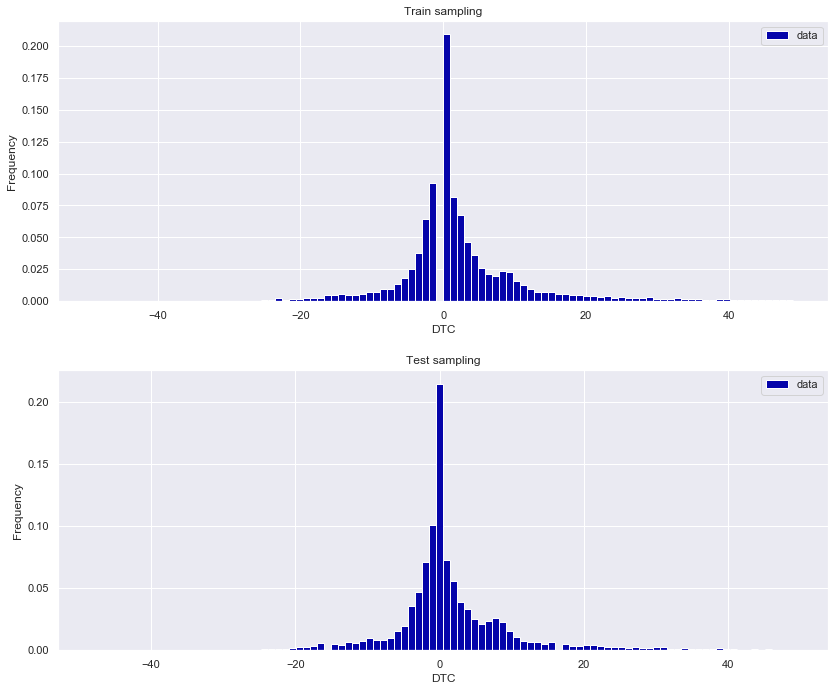

In [64]:
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 20})
plt.subplot(2,1,1)
#plt.hist(predict_results['train']['naive_bayes'], 100, label = 'bootstrap')
plt.hist(predict_results['train']['data'],100, label = 'data',color='#0504aa', density = True)
plt.legend()
plt.xlabel('DTC')
plt.ylabel('Frequency')
plt.title('Train sampling')

plt.subplot(2,1,2)
#plt.hist(predict_results['train']['naive_bayes'], 100, label = 'bootstrap')
plt.hist(predict_results['test']['data'],100, label = 'data',color='#0504aa', density = True)

plt.legend()
plt.xlabel('DTC')
plt.ylabel('Frequency')
plt.title('Test sampling')
plt.tight_layout()
plt.show()

In [65]:
results['naive_bayes']['predict']['train']

,xt,data,naive_bayes
0,170521-31101,23,-2
1,210452-32501,1,-1
2,170508-31101,-2,-1
3,131073-32561,0,-3
4,270910-31501,-1,-1
...,...,...,...
46059,178992-31101,-2,2
46060,299566-31501,-1,14
46061,298574-31501,0,-2
46062,299103-31501,-2,3


### (0) Train decision tree

In [66]:
%%time
model_name = 'tree_factors'
model_type = 'regression_tree'
hyperparam_dict = {
                   'criterion': ['mse'], 
                   'max_depth': [2, 4, 5, 10],
                   'min_samples_split': [5, 10, 15]
                  }

best_model, validation_results, grid_model = models.train_model_continuous(x_factors, y,\
                                                                           model_type, hyperparam_dict,\
                                                                           search_type, cv = 5)
predict_results = models.organize_results(best_model, model_name, x_factors, y)
metrics = dm.evaluation_metrics(predict_results, model_name)

# Save all results per given MODEL
results[model_name] = {
                       'hyperparam': hyperparam_dict,
                       'best_model': best_model,
                       'validation_results': validation_results,
                       'grid_model': grid_model,
                       'predict': predict_results,
                       'metrics': metrics,
                       'model_type': model_type,
                       'x': x_factors,
                       'search_type': search_type
                       }

Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
CPU times: user 2.2 s, sys: 52.3 ms, total: 2.25 s
Wall time: 2.26 s


### (1) Train LASSO

In [67]:
%%time
model_name = 'lasso_factors'
model_type = 'lasso'
hyperparam_dict = {
                   'alpha': np.linspace(0.1, 10, 100), 
                  }


best_model, validation_results, grid_model = models.train_model_continuous(x_factors, y, 'lasso', hyperparam_dict, \
                                                                           search_type)
predict_results = models.organize_results(best_model, model_name, x_factors, y)
metrics = dm.evaluation_metrics(predict_results, model_name)

# Save all results per given MODEL
results[model_name] = {
                       'hyperparam': hyperparam_dict,
                       'best_model': best_model,
                       'validation_results': validation_results,
                       'grid_model': grid_model,
                       'predict': predict_results,
                       'metrics': metrics,
                       'model_type': model_type,
                       'x': x_factors,
                       'search_type': search_type
                      }

Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
CPU times: user 1.06 s, sys: 25 ms, total: 1.09 s
Wall time: 281 ms


### (2) Train lightGBM on lasso selected features 
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [68]:
%%time
# Choose LASSO selected ft only
coeff_tmp = dm.assess_model_coefficients(results, 'lasso_factors')
lasso_selected_ft = list(coeff_tmp['ft_name'])

x_factors_lasso = {}
x_factors_lasso['train'] = train[lasso_selected_ft]
x_factors_lasso['test'] = test[lasso_selected_ft]

# Specify model
model_name = 'lightGBM_lasso_factors'
model_type = 'lightGBM'
hyperparam_dict = {
                    'metric': ['l1'],
                    'learning_rate': [0.01, 0.05],
                    'n_estimators': [20, 40],
                    'num_leaves': [10, 20, 50],
                    'min_data_in_leaf': [20, 50, 100],
                    'max_depth': [3, 4, 5, 10],
                    'feature_fraction': [0.7, 0.9]
                    }

best_model, validation_results, grid_model = models.train_model_continuous(x_factors_lasso, y,\
                                                                           model_type, hyperparam_dict, search_type)
predict_results = models.organize_results(best_model, model_name, x_factors_lasso, y)
metrics = dm.evaluation_metrics(predict_results, model_name)

# Save all results per given MODEL
results[model_name] = {
                       'hyperparam': hyperparam_dict,
                       'best_model': best_model,
                       'validation_results': validation_results,
                       'grid_model': grid_model,
                       'predict': predict_results,
                       'metrics': metrics,
                       'model_type': model_type,
                       'x': x_factors_lasso,
                       'search_type': search_type
                      }

Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
CPU times: user 14.4 s, sys: 433 ms, total: 14.8 s
Wall time: 1.97 s


### (3) Train lightGBM on full set of features

In [69]:
%%time
model_name = 'lightGBM_factors'
model_type = 'lightGBM'
hyperparam_dict = {
                    'metric': ['l1'],
                    'learning_rate': [0.01, 0.05],
                    'n_estimators': [20, 40],
                    'num_leaves': [10, 20, 50],
                    'min_data_in_leaf': [20, 50, 100],
                    'max_depth': [3, 4, 5, 10],
                    'feature_fraction': [0.7, 0.9]
                    }
best_model, validation_results, grid_model = models.train_model_continuous(x_factors, y,\
                                                                           model_type, hyperparam_dict, search_type)
predict_results = models.organize_results(best_model, model_name, x_factors, y)
metrics = dm.evaluation_metrics(predict_results, model_name)

# Save all results per given MODEL
results[model_name] = {
                       'hyperparam': hyperparam_dict,
                       'best_model': best_model,
                       'validation_results': validation_results,
                       'grid_model': grid_model,
                       'predict': predict_results,
                       'metrics': metrics,
                       'model_type': model_type,
                       'x': x_factors,
                       'search_type': search_type
                      }

Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
CPU times: user 16.8 s, sys: 512 ms, total: 17.3 s
Wall time: 2.28 s


In [70]:
results['lightGBM_factors']['best_model']

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9, importance_type='split', learning_rate=0.05,
              max_depth=10, metric='l1', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=40, n_jobs=-1, num_leaves=20, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbose=1)

### Add stacked model:

- First we have combine existing trained model together

In [71]:
models_list = list(results.keys())
train_test_data = list(results[models_list[0]]['metrics'].keys())
aggregated_metrics, aggregated_predictions = dm.aggregate_model_results(results)

# Assemble model predictions as features
x_stacked = {}
train_test_data = list(results[models_list[0]]['metrics'].keys())
for idx_data_set in train_test_data:  # Loop over train and test    
    x_stacked[idx_data_set] = aggregated_predictions[idx_data_set][models_list]

# (2) Analyze models' performance

#### Assess evaluation metrics

In [72]:
models_list = list(results.keys())
train_test_data = list(results[models_list[0]]['metrics'].keys())

#aggregated_metrics, aggregated_predictions = dm.aggregate_model_results(results)
for idx_data_set in train_test_data:  # Loop over train and test
    print(idx_data_set)
    aggregated_metrics[idx_data_set][models_list] = aggregated_metrics[idx_data_set][models_list].apply(pd.to_numeric,errors ='coerce')
    aggregated_metrics[idx_data_set][models_list] = aggregated_metrics[idx_data_set][models_list].round(2)
    display(aggregated_metrics[idx_data_set])

train


,metrics_name,naive_bayes,tree_factors,lasso_factors,lightGBM_lasso_factors,lightGBM_factors
0,r2_score,-1.00,0.43,0.23,0.46,0.46
1,mean_squared_error,177.21,50.42,68.10,47.85,47.45
2,mape,NaN,NaN,NaN,NaN,NaN


test


,metrics_name,naive_bayes,tree_factors,lasso_factors,lightGBM_lasso_factors,lightGBM_factors
0,r2_score,-1.15,0.34,0.27,0.37,0.40
1,mean_squared_error,170.40,52.41,57.56,50.03,47.66
2,mape,NaN,NaN,NaN,NaN,NaN


#### Plot model predictions vs data

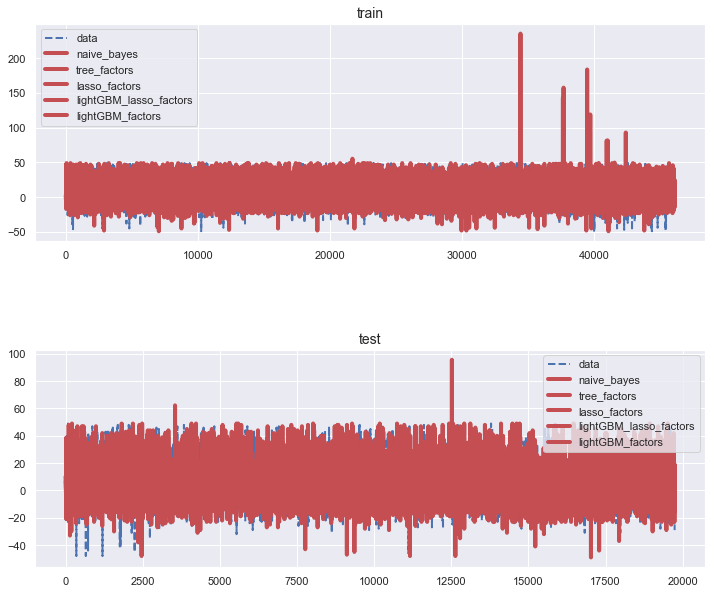

In [73]:
plt.figure(figsize=(12,10))
data_sets = ['train', 'test']
q = 1
models_list = list(results.keys())


for idx_data_set in data_sets:
    plt.subplot(2,1,q)
    tmp = aggregated_predictions[idx_data_set]
    plt.plot( tmp['data'], 'b--', linewidth = 2,  label = 'data')

    for idx_model in models_list:  # Loop over models
        plt.plot( tmp[idx_model], 'r', linewidth = 4, label = idx_model)

    plt.title(idx_data_set, fontsize = 14)
    plt.subplots_adjust(hspace=.5)
    plt.legend()
    q+=1
        
plt.show()

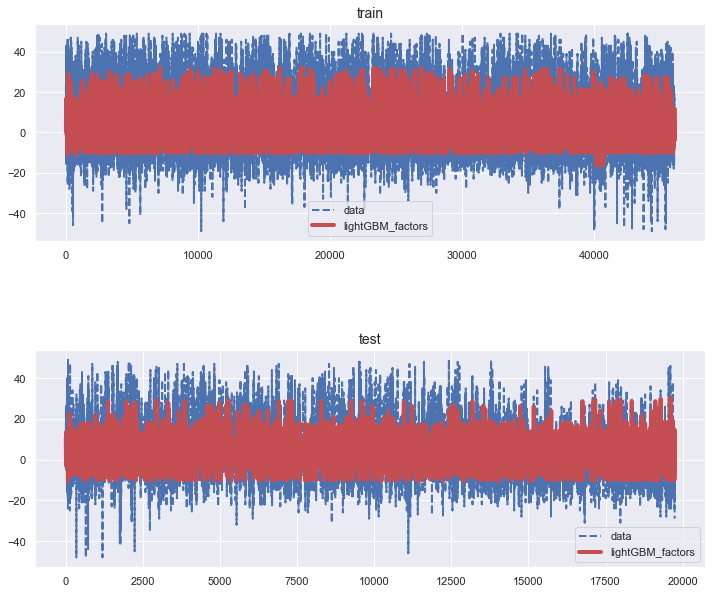

In [74]:
plt.figure(figsize=(12,10))
q = 1
for idx_data_set in data_sets:
    plt.subplot(2,1,q)
    tmp = aggregated_predictions[idx_data_set]
    plt.plot( tmp['data'], 'b--', linewidth = 2,  label = 'data')

    
    plt.plot( tmp[idx_model], 'r', linewidth = 4, label = idx_model)

    plt.title(idx_data_set, fontsize = 14)
    plt.subplots_adjust(hspace=.5)
    plt.legend()
    q+=1
        
plt.show()

#### Calculate errors

In [75]:
columns_list = []
columns_list = factors_ft.copy()
columns_list.append('xt')
columns_list.append('DTC')
columns_list.append('TRX_DATE')
columns_list.append('RECEIPT_DATE')
    
for idx_model in models_list:
    results[idx_model]['errors'] = {}
    
    results[idx_model]['errors']['train'] = pd.DataFrame()
    results[idx_model]['errors']['test'] = pd.DataFrame() 
    
    results[idx_model]['errors']['train'] = train[columns_list]
    results[idx_model]['errors']['test'] = test[columns_list]
    
    for idx_data_set in data_sets:  # Loop data
        results[idx_model]['errors'][idx_data_set ]= pd.merge(results[idx_model]['errors']\
                                           [idx_data_set ] , results[idx_model]['predict']\
                                                [idx_data_set ][['xt',idx_model]], on = 'xt').copy(deep = True)

        results[idx_model]['errors'][idx_data_set ]['errors'] = results[idx_model]['errors'][idx_data_set ]\
                                                         ['DTC'] - results[idx_model]['errors']\
                                                         [idx_data_set ][idx_model]

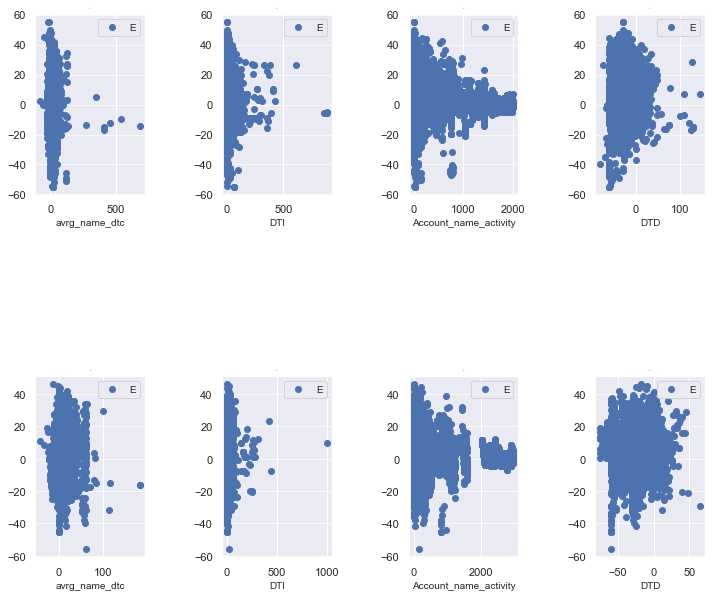

In [76]:
plt.figure(figsize=(12,10))
data_sets = ['train', 'test']
q = 1
models_list = list(results.keys())
idx_model = 'lightGBM_factors'
feature_list = ['avrg_name_dtc', 'DTI','Account_name_activity', 'DTD']

for idx_data_set in data_sets:
    
    tmp = results[idx_model]['errors'][idx_data_set ]
    
    for idx_feature in feature_list:
        plt.subplot(2,4,q)
        plt.scatter( tmp[idx_feature], tmp['errors'])
        plt.subplots_adjust(hspace = 1, wspace = 0.7)
        plt.legend('Errors', fontsize = 10 )
        plt.xlabel(idx_feature, fontsize = 10 )
        #plt.ylabel('Errors', fontsize = 10 )
        plt.grid(axis='y', alpha=0.75)
        plt.title(idx_data_set, fontsize = 1 )
    
        q+=1
        
plt.show()


#### Display feature importance or model coefficients

In [77]:
models_list
for idx_model in models_list[1:]:  # Loop over models
    print(idx_model)
    coeff = dm.assess_model_coefficients(results, idx_model)
    display(coeff)
    print('\n')

tree_factors


,ft_name,estimates
10,avrg_name_dtc,0.69
9,DTD,0.12
8,DTI,0.09
6,Account_name_activity,0.05
0,ACCOUNT_NAME,0.02
2,AMOUNT_DUE_ORIGINAL,0.01
3,PAYMENT_TERMS,0.01
5,TRX_DATE_Month,0.01
4,DESCRIPTION,0.00
11,avrg_name_amount,0.00




lasso_factors


,ft_name,estimates
10,avrg_name_dtc,0.34
8,DTI,0.09
9,DTD,0.05
1,LOCATION,0.00
6,Account_name_activity,0.00
11,avrg_name_amount,0.00
2,AMOUNT_DUE_ORIGINAL,-0.00
0,ACCOUNT_NAME,-0.00




lightGBM_lasso_factors


,ft_name,estimates
0,avrg_name_dtc,228
2,DTD,143
4,Account_name_activity,94
1,DTI,85
7,ACCOUNT_NAME,72
5,avrg_name_amount,66
6,AMOUNT_DUE_ORIGINAL,46
3,LOCATION,26




lightGBM_factors


,ft_name,estimates
10,avrg_name_dtc,208
9,DTD,135
6,Account_name_activity,87
8,DTI,80
0,ACCOUNT_NAME,46
3,PAYMENT_TERMS,45
11,avrg_name_amount,44
2,AMOUNT_DUE_ORIGINAL,35
4,DESCRIPTION,33
1,LOCATION,27


#### Assess tuning of the models 

In [78]:
# plt.figure(figsize=(12,10))
# q = 1
# for idx_model in models_list:  # Loop over models
#     print(idx_model)
#     plt.subplot(len(models_list),1,q)
#     tmp = results[idx_model]['validation_results']
    
#     ind_optimal = tmp['mean_validation_score'].nsmallest(1)
#     optimal_scenario = list(tmp['scenario'].iloc[ind_optimal])
#     plt.plot(tmp['mean_validation_score'], 'navy')
#     plt.plot(tmp['mean_validation_score'] - tmp['std_validation_score'], 'b--')
#     plt.plot(tmp['mean_validation_score'] + tmp['std_validation_score'], 'b--')   
#     plt.title('Validation score for \n ' + str(idx_model) + '\n' + str(optimal_scenario), fontsize = 16)
#     plt.xlabel('Scenario id', fontsize = 12)
#     plt.subplots_adjust(hspace=2.5)
#     q+=1
# plt.show()

#### Analyze model performace for special cases

In [79]:
# analyze the performance of the model when for historic customers
## focus on customers who already had deals with WFS
model_list = list(results.keys())
index_activity = {}

index_activity['test'] = pd.DataFrame()
index_activity['test'] = test.loc[test['Account_name_activity'] > 30]['xt'].copy(deep = True)

index_activity['train'] = pd.DataFrame()
index_activity['train'] = train.loc[train['Account_name_activity'] >30]['xt'].copy(deep = True)

predict_result = {}
#results_hist_activity = {}

import copy
results_hist_activity = copy.deepcopy(results)

for idx_model in model_list:
    
    for idx_data_set in train_test_data:
   
        results_hist_activity[idx_model]['predict'][idx_data_set] = \
        pd.merge(results_hist_activity[idx_model]['predict'][idx_data_set], index_activity[idx_data_set], \
                 on = 'xt', how = 'inner').copy(deep = True)
    
        
        predict_result[idx_data_set] = pd.DataFrame()
        predict_result[idx_data_set]= results_hist_activity[idx_model]['predict'][idx_data_set].copy(deep = True)
     
    metrics = pd.DataFrame()
    metrics = dm.evaluation_metrics(predict_result, idx_model)
    results_hist_activity[idx_model]['metrics'] = pd.DataFrame()
    results_hist_activity[idx_model]['metrics'] = metrics
    
    
aggregated_metrics_ha, aggregated_predictions_ha = dm.aggregate_model_results(results_hist_activity)

for idx_data_set in train_test_data:  # Loop over train and test
    print(idx_data_set)
    aggregated_metrics_ha[idx_data_set][models_list] = aggregated_metrics_ha[idx_data_set][models_list].apply(pd.to_numeric,errors ='coerce')
    aggregated_metrics_ha[idx_data_set][models_list] = aggregated_metrics_ha[idx_data_set][models_list].round(2)
    display(aggregated_metrics_ha[idx_data_set])

Finished loading model, total used 40 iterations
Finished loading model, total used 40 iterations
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
Can not compute MAPE due to zeros in data
train


,metrics_name,naive_bayes,tree_factors,lasso_factors,lightGBM_lasso_factors,lightGBM_factors
0,r2_score,-1.12,0.51,0.28,0.55,0.56
1,mean_squared_error,167.81,38.64,56.75,35.49,35.20
2,mape,NaN,NaN,NaN,NaN,NaN


test


,metrics_name,naive_bayes,tree_factors,lasso_factors,lightGBM_lasso_factors,lightGBM_factors
0,r2_score,-1.23,0.38,0.30,0.40,0.44
1,mean_squared_error,163.93,45.90,51.37,43.88,40.98
2,mape,NaN,NaN,NaN,NaN,NaN


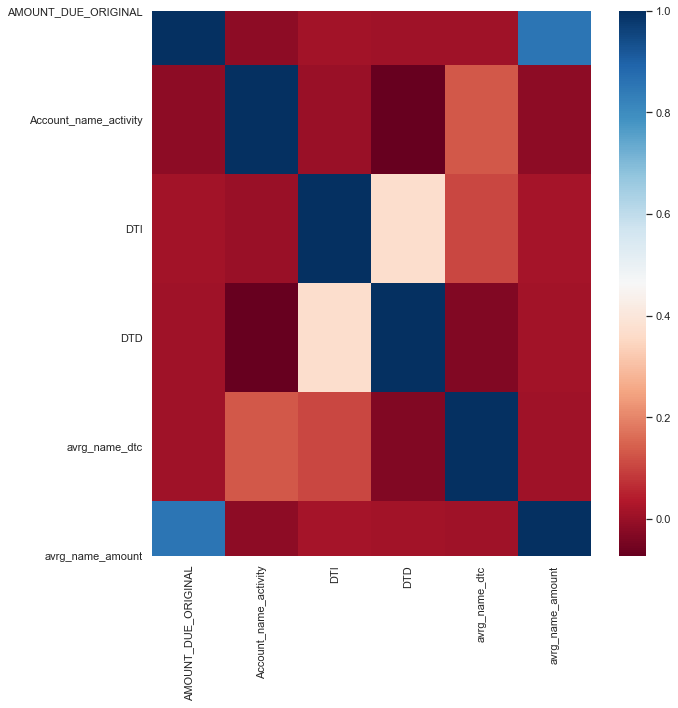

In [80]:
import seaborn as sns; sns.set()
plt.figure(figsize=(10,10))
factors_corr = x_factors['train'][['AMOUNT_DUE_ORIGINAL', 'Account_name_activity',\
                                  'DTI', 'DTD','avrg_name_dtc', 'avrg_name_amount']].corr()
sns.heatmap(factors_corr, 
        xticklabels=factors_corr.columns,
        yticklabels=factors_corr.columns,
        cmap='RdBu')

plt.tight_layout()

plt.show()

In [81]:
x_factors['train'].columns

Index(['ACCOUNT_NAME', 'LOCATION', 'AMOUNT_DUE_ORIGINAL', 'PAYMENT_TERMS',
       'DESCRIPTION', 'TRX_DATE_Month', 'Account_name_activity',
       'TRX_DATE_day', 'DTI', 'DTD', 'avrg_name_dtc', 'avrg_name_amount'],
      dtype='object')

# (4) Add Shap explanability

Code from here:
    - https://github.com/slundberg/shap
        
Paper is here:
    - https://github.com/slundberg/shap

In [82]:
### load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(results['lightGBM_factors']['best_model'])
shap_values = explainer.shap_values(x_factors['test'])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[4,:], x_factors['test'].iloc[4,:])

In [83]:
results['lightGBM_factors']['errors']['test']

abs(results['lightGBM_factors']['errors']['test']['errors']).nsmallest(20) 
abs(results['lightGBM_factors']['errors']['test'].loc[(results['lightGBM_factors']['errors']['test']\
                                                      ['Account_name_activity'] < 6) & \
                                                       (results['lightGBM_factors']['errors']['test']\
                                                      ['lightGBM_factors']> 15)]\
    ['errors']).nsmallest(20) 

4565      0.097912
481       0.567009
16228     0.568483
7174      1.139254
16335     1.720392
12912     2.097912
10270     2.835393
6786      3.068717
8682      3.535394
14726     3.535398
13331     3.574492
7267      3.584524
9476      7.691229
4887      8.097912
15660     8.953479
5235      9.217465
12827     9.425989
5684      9.746792
17617    11.624215
9555     12.225418
Name: errors, dtype: float64

In [84]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[12827 ,:], x_factors['test'].iloc[12827 ,:])

In [85]:
results['lightGBM_factors']['errors']['test'].iloc[12827 ,:]

ACCOUNT_NAME                            2004
LOCATION                                 447
AMOUNT_DUE_ORIGINAL              1.78131e+06
PAYMENT_TERMS                             29
DESCRIPTION                               11
TRX_DATE_Month                             8
Account_name_activity                      2
TRX_DATE_day                               0
DTI                                       12
DTD                                      -18
avrg_name_dtc                             36
avrg_name_amount                 1.63904e+06
xt                              101281-31511
DTC                                       27
TRX_DATE                 2019-05-03 00:00:00
RECEIPT_DATE             2019-06-17 00:00:00
lightGBM_factors                      17.574
errors                               9.42599
Name: 12827, dtype: object

In [86]:
test.iloc[12827 ,:]

index                                           1209
ACCOUNT_NUMBER                                102154
ACCOUNT_NAME                                    2004
CUST_ACCOUNT_ID                               103596
LOCATION                                         447
xt                                      101281-31511
TRX_DATE                         2019-05-03 00:00:00
TRANSACTION_STATUS                                OP
AMOUNT_DUE_ORIGINAL                      1.78131e+06
AMOUNT_DUE_REMAINING                               0
POI_NUMBER                                   3084756
LIFT_DATE                        2019-04-21 00:00:00
DUE_DATE                         2019-05-21 00:00:00
RECEIPT_NUMBER                      AUR17069Q2FCZVGG
RECEIPT_DATE                     2019-06-17 00:00:00
APPLY_DATE                       2019-06-17 00:00:00
AMOUNT_APPLIED                           1.78131e+06
RECEIPT_STATUS                                   APP
PAYMENT_TERMS                                 

In [87]:
raw.loc[raw['xt'] == '300563-31501'][['PAYMENT_TERMS', 'ACCOUNT_NAME', 'DESCRIPTION']]

,PAYMENT_TERMS,ACCOUNT_NAME,DESCRIPTION
45430,30 DDD BY TT,WOODSIDE ENERGY (MYANMAR) PTE LTD,TRADE INVOICE


# (5) Save Results

In [88]:
with open('results.p', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
train.to_csv('train.csv')
test.to_csv('test.csv')

In [36]:
import xgboost
import shap

